In [40]:
from functools import partial

import astropy.units as u
from astropy.coordinates import spherical_to_cartesian, cartesian_to_spherical
from scipy.spatial.distance import cdist

from src.common.camera import Camera
from src.common.conics import *
from src.common.coordinates import ENU_system
from src.matching.database import load_craters, CraterDatabase
from src.matching.position_estimation import derive_position_lsq
from src.matching.projective_invariants import CoplanarInvariants
from src.common.robbins import extract_robbins_dataset

In [41]:
lat_cat, long_cat, major_cat, minor_cat, psi_cat, crater_id = extract_robbins_dataset(
    load_craters("../data/lunar_crater_database_robbins_2018.csv", diamlims=[2, 30], ellipse_limit=1.4)
)
r_craters_cat = np.array(np.array(spherical_to_cartesian(const.RMOON, lat_cat, long_cat))).T[..., None]
C_craters_cat = conic_matrix(major_cat, minor_cat, psi_cat)

In [42]:
resolution = (256, 256)

# Camera parameters can be derived from RNG
cam_lat, cam_long = map(np.radians, (45., 45.))
cam_alt = 120

cam = ConicProjector.from_coordinates(cam_lat, cam_long, cam_alt, resolution=resolution)

# cam.T = (Rotation.from_matrix(cam.T) * Rotation.from_euler('x', 0, degrees=True)).as_matrix()

dist = cam_alt / np.cos(np.radians(cam.fov[0]/2)*np.sqrt(2) * 1.0)
vicinity = (np.sqrt(np.sum(np.square(r_craters_cat - cam.r), axis=1)) < dist).ravel()
r_craters = r_craters_cat[vicinity]
C_craters = C_craters_cat[vicinity]
A_craters = cam.project_crater_conics(C_craters, r_craters)

crater_centers = cam.project_crater_centers(r_craters)

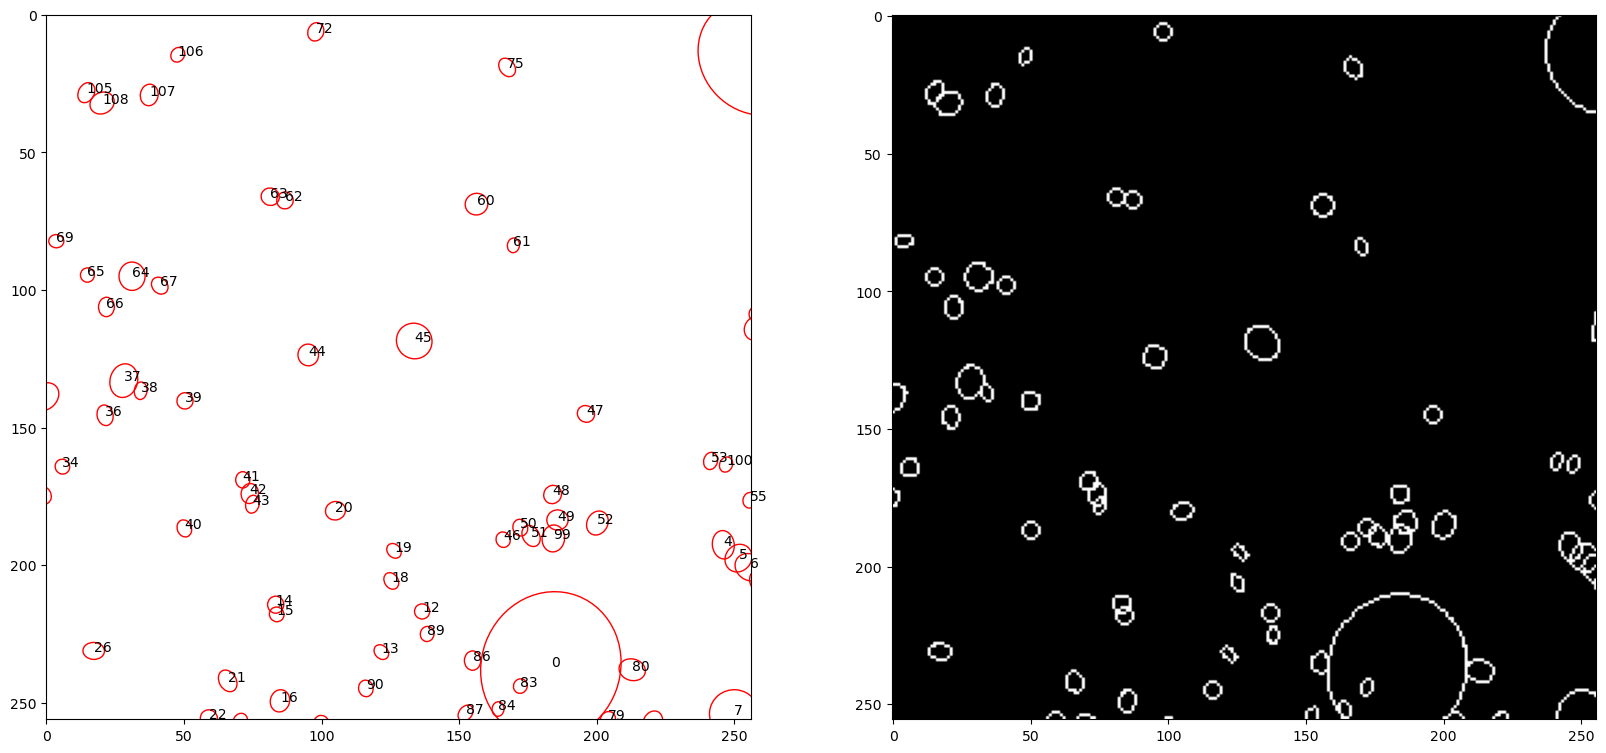

In [43]:
plt.style.use('default')

fig, axes = plt.subplots(1, 2, figsize=(20, 40), subplot_kw={'aspect': 'equal'})

plot_conics(A_craters, resolution=cam.resolution, plot_centers=True, ax=axes[0])
detection_order = np.argsort(cdist(crater_centers, np.array(cam.resolution)[None, :]/2).squeeze())

# plot_conics(A_craters[detection_order], resolution=cam.resolution, plot_centers=True, ax=axes[1])

img_ellipses = generate_mask(A_craters, resolution=resolution, instancing=False)

axes[1].imshow(img_ellipses, cmap='Greys_r')
# fig.savefig('output/crater_mask_example.pdf', bbox_inches = 'tight', pad_inches = 0)

In [44]:
# db = CraterDatabase.from_file("../data/lunar_crater_database_robbins_2018.csv", diamlims=[3, 30], latlims=[20, 70], longlims=[20, 70], radius=100, ellipse_limit=1.4)
db = CraterDatabase(lat_cat[vicinity], long_cat[vicinity], major_cat[vicinity], minor_cat[vicinity], psi_cat[vicinity], radius=500)

In [45]:
sigma_pix = 0.5

n_det = len(A_craters)
# Add noise
major_det, minor_det = ellipse_axes(A_craters)
psi_det = ellipse_angle(A_craters)
r_craters_det = conic_center(A_craters)

major_det += np.random.uniform(-sigma_pix, sigma_pix, size=n_det)
minor_det += np.random.uniform(-sigma_pix, sigma_pix, size=n_det)
psi_det += np.random.normal(scale=(10/180)*np.pi, size=n_det)
r_craters_det += np.random.normal(-sigma_pix, sigma_pix, size=r_craters_det.shape)

A_craters_noisy = conic_matrix(major_det, minor_det, psi_det, *r_craters_det.T)

In [46]:
def distance_metric(A_i: np.ndarray, A_j: np.ndarray):
    Y_i = -A_i[:, :2, :2]
    Y_j = -A_j[:, :2, :2]

    y_i = np.expand_dims(conic_center(A_i), axis=-1)
    y_j = np.expand_dims(conic_center(A_j), axis=-1)

    d = np.arccos(
        (4*np.sqrt(LA.det(Y_i)*LA.det(Y_j)) / (LA.det(Y_i + Y_j))) \
        * np.exp(-0.5 * (y_i - y_j).transpose(0,2,1) @ Y_i @ LA.inv(Y_i + Y_j) @ Y_j @ (y_i - y_j)).flatten()
    )

    return d.flatten()

def hypothesis_match(A_i, A_j, sigma_img, threshold=13.276):
    d_GA = distance_metric(A_i, A_j)

    a_i, b_i = ellipse_axes(A_i)

    sigma = (0.85 / np.sqrt(a_i * b_i)) * sigma_img

    return (d_GA ** 2) / (sigma ** 2) < threshold

In [47]:
batch_size = 1000
top_n = 3

max_matches = 60

assert max_matches % 3 == 0, "Matches are appended in sets of 3!"

top_n = [top_n] if top_n == 1 else top_n

A_matched = np.full((max_matches, 3, 3), -1, np.float64)
C_matched = np.full((max_matches, 3, 3), -1, np.float64)
r_matched =  np.full((max_matches, 3, 1), -1, np.float64)

est_r = np.zeros((max_matches//3, 3, 1), np.float64)

crater_triads, features = next(CoplanarInvariants.match_generator(A_craters=A_craters_noisy, max_iter=10, batch_size=batch_size))
dummy_position = np.zeros_like(cam.r, np.float64)
match_projector = ConicProjector(attitude=cam.T, fov=cam.fov, resolution=cam.resolution)
min_n = db.query(features, k=top_n)

match_est_pos_loop = np.zeros((top_n, batch_size, 3, 1))

i = 0
for p, (candidates, triad) in enumerate(zip(min_n, crater_triads)):
    r_craters_match, C_craters_match = db[candidates]
    for q, (r, C) in enumerate(zip(r_craters_match, C_craters_match)):
        est_pos = derive_position_lsq(A_craters_noisy[triad], r, C, cam.T, cam.K)
        match_est_pos_loop[q, p] = match_projector.r
        alt = LA.norm(est_pos)
        if not const.RMOON < alt < const.RMOON + 500:
            continue
        match_projector.r = est_pos
        A_craters_projected = match_projector.project_crater_conics(C, r)

        A_i = scale_det(A_craters_projected)
        A_j = scale_det(A_craters_noisy[triad])
        h = hypothesis_match(A_i, A_j, 0.5)
        if all(h):
            print('MATCH')
            print(f"\tPosition error: {(LA.norm(cam.r.ravel() - match_projector.r.ravel()) * u.km).to(u.m):.2f}")
            A_matched[i:i+3, ...] = A_i
            C_matched[i:i+3, ...] = C
            r_matched[i:i+3, ...] = r

            cum_r = derive_position_lsq(A_matched[:i+3], r_matched[:i+3], C_matched[:i+3], cam.T, cam.K)
            print(f"\tCumulative position error: {(LA.norm(cam.r.ravel() - cum_r.ravel()) * u.km).to(u.m):.2f}")
            est_r[i//3] = cum_r

            i += 3
            break

    if i >= max_matches:
        break

MATCH
	Position error: 390.67 m
	Cumulative position error: 390.67 m
MATCH
	Position error: 1110.70 m
	Cumulative position error: 345.24 m
MATCH
	Position error: 499.37 m
	Cumulative position error: 378.95 m
MATCH
	Position error: 1158.86 m
	Cumulative position error: 370.57 m
MATCH
	Position error: 9790.72 m
	Cumulative position error: 375.73 m
MATCH
	Position error: 269.02 m
	Cumulative position error: 369.18 m
MATCH
	Position error: 1653.38 m
	Cumulative position error: 351.16 m
MATCH
	Position error: 521.26 m
	Cumulative position error: 373.97 m
MATCH
	Position error: 154.75 m
	Cumulative position error: 335.03 m
MATCH
	Position error: 1666.60 m
	Cumulative position error: 332.39 m
MATCH
	Position error: 371.05 m
	Cumulative position error: 321.40 m
MATCH
	Position error: 357.39 m
	Cumulative position error: 330.23 m
MATCH
	Position error: 2121.13 m
	Cumulative position error: 331.03 m
MATCH
	Position error: 536.51 m
	Cumulative position error: 385.23 m
MATCH
	Position error: 4989.

Text(0, 0.5, '$||\\Delta \\mathbf{x}||_2$')

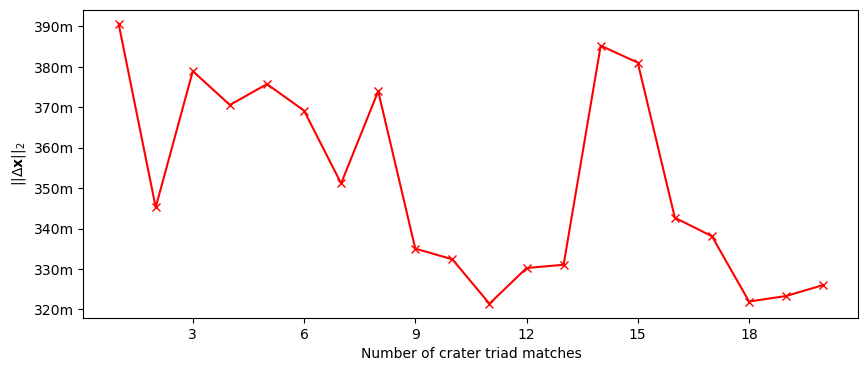

In [48]:
import matplotlib.ticker as ticker

plt.style.use('default')
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(np.arange(1, len(est_r)+1), LA.norm(cam.r - est_r[:i//3], axis=1).flatten()*1000, '-rx')
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.im'))
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.xlabel("Number of crater triad matches")
plt.ylabel("$||\Delta \mathbf{x}||_2$")

In [49]:
fig.savefig("../output/triad_matching_example.pdf")

In [50]:
@njit
def pos_lsq_broadcast(A, b):
    out = np.empty((A.shape[0], 3, 1))

    for ii in range(A.shape[0]):
        Q, R = LA.qr(A[ii])
        Qb = np.dot(Q.T, b[ii])
        out[ii] = LA.solve(R, Qb)
    return out

In [51]:
def calculate_position(A_detections,
                       db,
                       T,
                       K,
                       batch_size=1000,
                       top_n=3,
                       sigma_pix=1,
                       max_matched_triads=30,
                       max_alt=500
                       ):
    top_n = [top_n] if top_n == 1 else top_n

    # Generate matchable features to query the database index with
    crater_triads, index = next(CoplanarInvariants.match_generator(
        A_craters=A_detections,
        max_iter=1,
        batch_size=batch_size
    ))

    # Get top-k matches w.r.t. index
    min_n = db.query(index, k=top_n)

    A_match = A_detections[crater_triads]
    r_match, C_match = map(partial(np.moveaxis, source=1, destination=0), db[min_n])

    S = np.concatenate((np.identity(2), np.zeros((1, 2))), axis=0)
    k = np.array([0., 0., 1.])[:, None]

    B_craters = cam.T @ cam.K.T @ A_match @ cam.K @ LA.inv(cam.T)

    confirmations = np.full((top_n, batch_size), False)

    for i, (r, C) in enumerate(zip(r_match, C_match)):

        T_EM = np.concatenate(ENU_system(r), axis=-1)
        T_ME = LA.inv(T_EM)

        A = (S.T @ T_ME @ B_craters).reshape(-1, 6, 3)
        b = (S.T @ T_ME @ B_craters @ r).reshape(-1, 6, 1)
        match_est_pos = pos_lsq_broadcast(A, b)

        H_Mi = np.concatenate((np.concatenate(ENU_system(r), axis=-1) @ S, r), axis=-1)
        P_MC = cam.K @ LA.inv(cam.T) @ np.concatenate((np.tile(np.identity(3), (len(match_est_pos), 1, 1)), -match_est_pos), axis=2)
        H_C = P_MC[:, None, ...] @ np.concatenate((H_Mi, np.tile(k.T[None, ...], (len(H_Mi), 3, 1, 1))), axis=-2)
        A_projected = LA.inv(H_C.transpose(0, 1, 3, 2)) @ C @ LA.inv(H_C)

        Y_i = -scale_det(A_projected)[..., :2, :2]
        Y_j = -scale_det(A_match)[..., :2, :2]

        y_i = np.expand_dims(conic_center(A_projected), axis=-1)
        y_j = np.expand_dims(conic_center(A_match), axis=-1)

        d = np.arccos(
            (4*np.sqrt(LA.det(Y_i)*LA.det(Y_j)) / (LA.det(Y_i + Y_j))) \
            * np.exp(-0.5 * (y_i - y_j).transpose(0,1,3,2) @ Y_i @ LA.inv(Y_i + Y_j) @ Y_j @ (y_i - y_j)).squeeze()
        )

        a_i, b_i = ellipse_axes(A_projected)

        sigma = (0.85 / np.sqrt(a_i * b_i)) * sigma_pix

        mask = np.logical_and(
           np.logical_and.reduce(((d / sigma) ** 2) <= 13.276, axis=1),
           LA.norm(match_est_pos, axis=(-2, -1)) < const.RMOON + max_alt,
           LA.norm(match_est_pos, axis=(-2, -1)) > const.RMOON
           )

        confirmations[i] = mask

    n_idx, b_idx = np.where(confirmations)

    if len(n_idx) == 0:
        return np.full((3, 1), -1)

    return derive_position_lsq(A_match[b_idx].reshape(-1, 3, 3),
          r_match[n_idx, b_idx].reshape(-1, 3, 1),
          C_match[n_idx, b_idx].reshape(-1, 3, 3),
          T,
          K)


est_r = calculate_position(A_craters_noisy, db, cam.T, cam.K, sigma_pix=sigma_pix)
print(f"\tPosition error: {(LA.norm(cam.r.ravel() - est_r.ravel()) * u.km).to(u.m):.2f}")

<ipython-input-50-f5213a6271fb>:7: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, C))
  Qb = np.dot(Q.T, b[ii])


	Position error: 290.76 m


C:\Users\w_dop\miniconda3\envs\crater-detection\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in sqrt
C:\Users\w_dop\miniconda3\envs\crater-detection\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: overflow encountered in exp
C:\dev\workspace\crater-detection\src\common\conics.py:135: RuntimeWarning: invalid value encountered in sqrt
  axes = np.sqrt(1 / lambdas)


In [52]:
est_r = db.query_position(A_craters_noisy, cam.T, cam.K, sigma_pix=sigma_pix)
print(f"\tPosition error: {(LA.norm(cam.r.ravel() - est_r.ravel()) * u.km).to(u.m):.2f}")

	Position error: 285.99 m


C:\dev\workspace\crater-detection\src\matching\position_estimation.py:353: RuntimeWarning: invalid value encountered in sqrt
  (4 * np.sqrt(LA.det(Y_i) * LA.det(Y_j)) / (LA.det(Y_i + Y_j))) \
C:\dev\workspace\crater-detection\src\matching\position_estimation.py:354: RuntimeWarning: overflow encountered in exp
  * np.exp(-0.5 * (y_i - y_j).transpose(0, 1, 3, 2) @ Y_i @ LA.inv(Y_i + Y_j) @ Y_j @ (y_i - y_j)).squeeze()
C:\dev\workspace\crater-detection\src\common\conics.py:135: RuntimeWarning: invalid value encountered in sqrt
  axes = np.sqrt(1 / lambdas)


# MC Simulation

In [53]:
latlims = (30, 60)
longlims = (30, 60)
diamlims = (2, 30)
ellipse_limit = 1.2
arclims = 0.5

triad_radius = 50

lat_cat, long_cat, major_cat, minor_cat, psi_cat, crater_id = extract_robbins_dataset(
    load_craters(
        "../data/lunar_crater_database_robbins_2018.csv",
        latlims=latlims,
        longlims=longlims,
        diamlims=diamlims,
        ellipse_limit=ellipse_limit,
        arc_lims=arclims
    )
)
db = CraterDatabase(lat_cat, long_cat, major_cat, minor_cat, psi_cat, radius=triad_radius)

r_craters_cat = np.array(np.array(spherical_to_cartesian(const.RMOON, lat_cat, long_cat))).T[..., None]
C_craters_cat = conic_matrix(major_cat, minor_cat, psi_cat)

In [61]:
test_size = 30
resolution = (256, 256)

position_dataset = np.empty((test_size, 3, 1), np.float64)
attitude_dataset = np.empty((test_size, 3, 3), np.float64)

est_position_dataset = np.empty((test_size, 3, 1), np.float64)

# Error factors
position_noise = 0.01
axis_noise = 0.01
angle_noise = 0.15

for i in range(test_size):

    lat = np.random.uniform(*latlims)
    long = np.random.uniform(*longlims)
    cam_alt = np.random.uniform(150, 250)
    cam = ConicProjector.from_coordinates(lat,
                                  long,
                                  cam_alt,
                                  convert_to_radians=True,
                                  resolution=resolution
                                  )

    # save cam.r, sol_incidence
    position_dataset[i] = cam.r

    # Rotations are incremental (order matters)
    cam.rotate('roll', np.random.uniform(0, 360))
    cam.rotate('pitch', np.random.uniform(-30, 30))
    cam.rotate('yaw', np.random.uniform(-30, 30))

    # save cam.T
    attitude_dataset[i] = cam.T

    visible = (cdist(r_craters_cat.squeeze(), cam.r.T) <= np.sqrt(2 * cam_alt * const.RMOON + cam_alt**2)).ravel()
    r_craters = r_craters_cat[visible]
    C_craters = C_craters_cat[visible]

    r_craters_img = cam.project_crater_centers(r_craters)
    in_image = np.logical_and.reduce(np.logical_and(r_craters_img > -20, r_craters_img < cam.resolution[0]+20), axis=1)

    r_craters = r_craters[in_image]
    C_craters = C_craters[in_image]

    A_craters = cam.project_crater_conics(C_craters, r_craters)
    n_det = len(A_craters)

    major_det, minor_det = ellipse_axes(A_craters)
    psi_det = ellipse_angle(A_craters)
    r_craters_det = conic_center(A_craters)

    major_det *= 1 + np.random.normal(0, axis_noise, n_det)
    minor_det *= 1 + np.random.normal(0, axis_noise, n_det)
    psi_det *= 1 + np.random.normal(0, angle_noise, n_det)
    r_craters_det *= 1 + np.random.normal(-position_noise, position_noise, r_craters_det.shape)

    A_craters_noisy = conic_matrix(major_det, minor_det, psi_det, *r_craters_det.T)
    if n_det >= 6:
        est_position_dataset[i] = db.query_position(A_craters_noisy, cam.T, cam.K,
                                                    regression_type='ransac',
                                                    sigma_pix=5,
                                                    batch_size=1000,
                                                    top_n=20,
                                                    max_trials=1000,
                                                    residual_threshold=10000.)
    else:
        est_position_dataset[i, ...] = -1

0

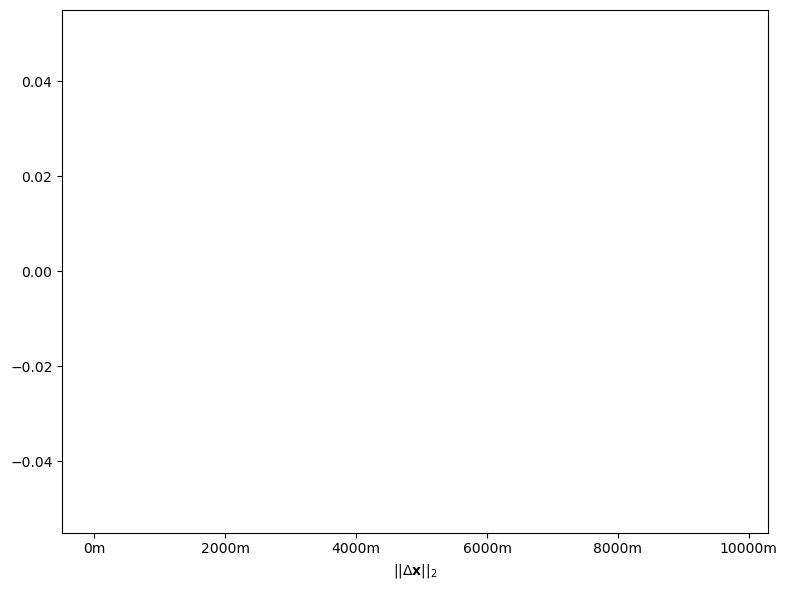

In [62]:
import scipy.stats as stats

plt.style.use('default')

matched_positions = np.logical_and.reduce(~np.isnan(est_position_dataset), axis=(1,2))
err = LA.norm(est_position_dataset[matched_positions] - position_dataset[matched_positions], axis=1).ravel()*1000
bins = np.arange(0, 10000, 200)
fig, ax = plt.subplots(figsize=(8, 6))

entries, bin_edges, patches = ax.hist(err, bins=bins)
ax.set_xlabel("$||\Delta \mathbf{x}||_2$")
ax.set_ylabel("")
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.im'))

fig.tight_layout()
fig.savefig("../output/total_error.pdf")
len(err)

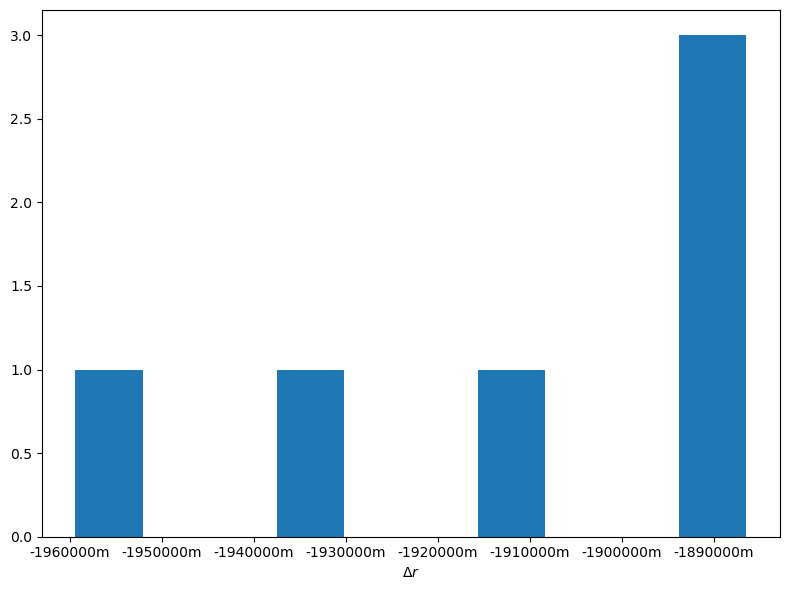

In [58]:
err_r, err_lat, err_lon = np.array(cartesian_to_spherical(*(est_position_dataset[matched_positions]).squeeze().T) -
                         np.array(cartesian_to_spherical(*(position_dataset[matched_positions]).squeeze().T)))

err_lat, err_lon = map(np.degrees, (err_lat, err_lon))

err_lon[err_lon > 180] -= 360

fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(err_r*1000)
ax.set_xlabel(r'$\Delta r$')
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.im'))
fig.tight_layout()
fig.savefig("../output/radial_error.pdf")

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
err_range = np.arange(-0.1, 0.1, 0.01)
h = ax.hist2d(err_lon, err_lat, bins=err_range, cmap='viridis')
ax.set_xlabel(r'$\Delta \lambda$')
ax.set_ylabel(r'$\Delta \varphi$')
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f$^{\circ}$'))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f$^{\circ}$'))
plt.colorbar(h[3], ax=ax)
fig.tight_layout()
fig.savefig("../output/coordinate_error.pdf")

In [ ]:
err_x, err_y, err_z = ((est_position_dataset[matched_positions] - position_dataset[matched_positions])*1000).squeeze().T
fig, ax = plt.subplots(2, 2, figsize=(8, 6))

err_range = np.arange(-6000, 6000, 200)

h = ax[0, 0].hist2d(err_x, err_y, bins=err_range, cmap='viridis')
ax[0, 0].set_xlabel('$\Delta X$')
ax[0, 0].set_ylabel('$\Delta Y$')

ax[1, 0].hist2d(err_x, err_z, bins=err_range, cmap='viridis')
ax[1, 0].set_xlabel('$\Delta X$')
ax[1, 0].set_ylabel('$\Delta Z$')

ax[0, 1].hist2d(err_y, err_z, bins=err_range, cmap='viridis')
ax[0, 1].set_xlabel('$\Delta Y$')
ax[0, 1].set_ylabel('$\Delta Z$')

ax[1, 1].axis('off')
# plt.colorbar(h[3], ax=ax[1, 1])
np.nanmean(err_x)

In [39]:
np.logical_and.reduce(~np.isnan(est_position_dataset), axis=(1,2))


array([False, False, False, ..., False, False, False])